In [1]:
from scipy.spatial.transform import Rotation as R
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from LightTransportSimulator.RayVectors.utils import nearest_intersected_object
from LightTransportSimulator.RayVectors.intersects import sphere_intersect
from LightTransportSimulator.RayVectors.vectors import *
from LightTransportSimulator.RayVectors.rays import *

In [3]:
camera = np.array([0, 0, 1])

In [4]:
width = 300
height = 200
aspect_ratio = width/height
screen = {'left': -1, 'top': 1 / aspect_ratio, 'right': 1, 'bottom': -1 / aspect_ratio}
max_depth = 3

In [5]:
light_source = { 'position': np.array([5, 5, 5]), 'ambient': np.array([1, 1, 1]), 'diffuse': np.array([1, 1, 1]), 'specular': np.array([1, 1, 1]) }

In [14]:
objects = [
    {'type': 'sphere', 'geom_props': { 'center': np.array([-0.2, 0, -1]), 'radius': 0.7 }, 'light_props': { 'ambient': np.array([0.1, 0, 0]), 'diffuse': np.array([0.7, 0, 0]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5 }},
    {'type': 'sphere', 'geom_props': { 'center': np.array([0.1, -0.3, 0]), 'radius': 0.1 }, 'light_props': { 'ambient': np.array([0.1, 0, 0.1]), 'diffuse': np.array([0.7, 0, 0.7]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5 }},
    {'type': 'sphere', 'geom_props': { 'center': np.array([-0.3, 0, 0]), 'radius': 0.15 }, 'light_props': { 'ambient': np.array([0, 0.1, 0]), 'diffuse': np.array([0, 0.6, 0]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5 }},
    {'type': 'triangle', 'geom_props': { 'a': np.array([-1.0,-1.0,0.0]), 'b': np.array([1.0,-1.0,0.0]), 'c': np.array([0.0,1.0,0.0]) }, 'light_props': { 'ambient': np.array([0, 0.1, 0]), 'diffuse': np.array([0, 0.6, 0]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5 }}
]

In [15]:
image = np.zeros((height, width, 3))

In [16]:
for i, y in enumerate(np.linspace(screen['top'], screen['bottom'], height)):
    for j, x in enumerate(np.linspace(screen['left'], screen['right'], width)):
        # screen is on origin
        pixel = np.array([x, y, 0])
        origin = camera
        end = pixel
        direction = normalize(end - origin)

        color = np.zeros((3))
        reflection = 1

        for k in range(max_depth):
            # check for intersections
            nearest_object, min_distance = nearest_intersected_object(objects, origin, end)
            if nearest_object is None:
                break

            intersection = origin + min_distance * direction

            if nearest_object['type'] == 'sphere':
                normal_to_surface = normalize(intersection - nearest_object['geom_props']['center'])
            else:
                ab = nearest_object['geom_props']['b'] - nearest_object['geom_props']['a']
                ac = nearest_object['geom_props']['c'] - nearest_object['geom_props']['a']
                normal_to_surface = np.cross(ab, ac)

            shifted_point = intersection + 1e-5 * normal_to_surface

            intersection_to_light = normalize(light_source['position'] - shifted_point)

            _, min_distance = nearest_intersected_object(objects, shifted_point, light_source['position'])
            intersection_to_light_distance = np.linalg.norm(light_source['position'] - intersection)
            is_shadowed = min_distance < intersection_to_light_distance

            if is_shadowed:
                break

            illumination = np.zeros((3))

            # ambiant
            illumination += get_ambience(nearest_object['light_props']['ambient'], light_source['ambient'])

            # diffuse
            illumination += get_diffuse(nearest_object['light_props']['diffuse'], light_source['diffuse'], intersection_to_light, normal_to_surface)

            # specular
            intersection_to_camera = normalize(camera - intersection)
            viewing_direction = normalize(intersection_to_light + intersection_to_camera)
            illumination += get_specular(nearest_object['light_props']['specular'], light_source['specular'], viewing_direction, normal_to_surface, nearest_object['light_props']['shininess'])

            # reflection
            color += reflection * illumination
            reflection *= nearest_object['light_props']['reflection']

            origin = shifted_point
            direction = reflected_ray(direction, normal_to_surface)

        image[i, j] = np.clip(color, 0, 1)
    # print("%d/%d" % (i + 1, height))


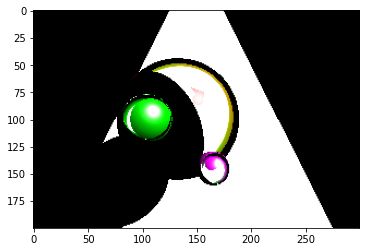

In [17]:
plt.imshow(image)

In [ ]:
plt.imsave('image.png', image)